# Visualize module overlap

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from io import BytesIO
from PIL import Image

from config import PIPELINE_RUN_DIR, AMIMS, NETWORKS, SEED_SETS
from functions import split_module_id, save_figure, load_merged_stats, expected_jaccard_index
prefix = "05"

In [2]:
path = os.path.join(PIPELINE_RUN_DIR, "main/results/mqc_summaries/jaccard_similarity_matrix_mqc.tsv")
path_no_seeds = os.path.join(PIPELINE_RUN_DIR, "main/results/mqc_summaries/jaccard_similarity_no_seeds_matrix_mqc.tsv")

In [3]:
amim_meta_df = pd.DataFrame.from_dict(AMIMS)
network_meta_df = pd.DataFrame.from_dict(NETWORKS)
seed_meta_df = pd.DataFrame.from_dict(SEED_SETS)

df = pd.read_csv(path, sep="\t")

ann_df = pd.DataFrame()
ann_df[["seed_id","network_id","amim_id"]] = df.ID.apply(split_module_id)
ann_df.set_index(df.ID, inplace=True)

no_seeds_df = pd.read_csv(path_no_seeds, sep="\t")
ann_no_seeds_df = pd.DataFrame()
ann_no_seeds_df[["seed_id","network_id","amim_id"]] = no_seeds_df.ID.apply(split_module_id)
ann_no_seeds_df.set_index(no_seeds_df.ID, inplace=True)

merged_df = load_merged_stats()
merged_df.set_index("sample_module", inplace=True, drop=True)

df.set_index("ID", inplace=True, drop=True)
no_seeds_df.set_index("ID", inplace=True, drop=True)

/home/johannes/miniforge3/envs/mdp_demonstration/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/johannes/miniforge3/envs/mdp_demonstration/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


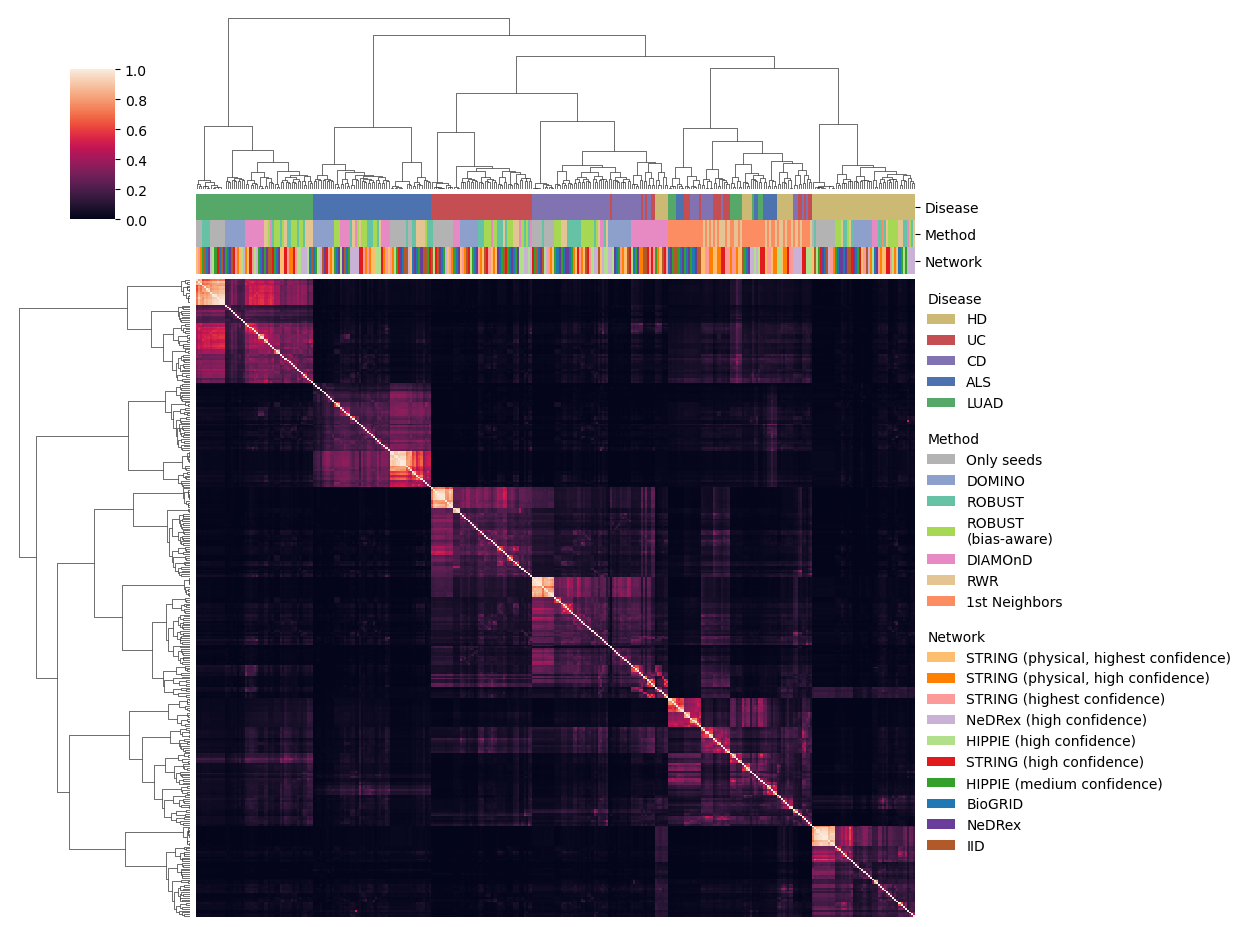

/home/johannes/miniforge3/envs/mdp_demonstration/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/johannes/miniforge3/envs/mdp_demonstration/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


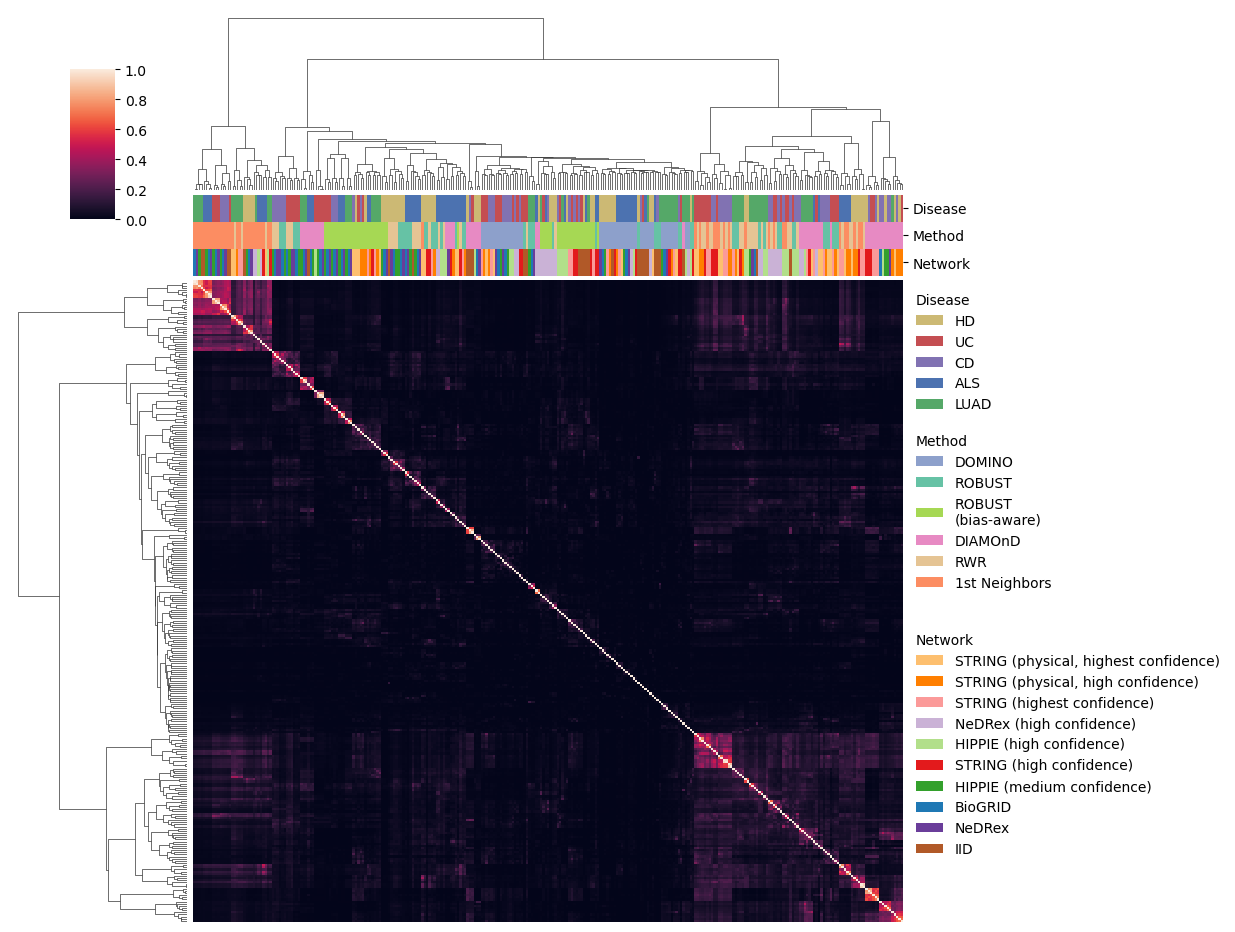

In [4]:
def combined_heatmap(df, ann_df, amim_meta_df, network_meta_df, seed_meta_df):
    color_df = pd.DataFrame()
    color_df["Disease"] = ann_df.seed_id.map(dict(zip(seed_meta_df.short, seed_meta_df.color)))
    color_df["Method"] = ann_df.amim_id.map(dict(zip(amim_meta_df.id, amim_meta_df.color)))
    color_df["Network"] = ann_df.network_id.map(dict(zip(network_meta_df.id, network_meta_df.color)))

    g = sns.clustermap(
        data=df,
        col_colors=color_df,
        figsize=(15, 15),
        cbar_pos=(0.05, 0.85, 0.03, 0.1),
        method="ward",
    )
    g.ax_heatmap.set_xticks([])
    g.ax_heatmap.set_yticks([])
    g.ax_heatmap.set_ylabel("")
    g.ax_heatmap.set_xlabel("")

    handles = [Patch(facecolor=color, label=group) for group, color in zip(seed_meta_df.short, seed_meta_df.color)]
    disease_legend  = g.ax_heatmap.legend(
        handles=handles,
        title='Disease',
        loc='upper left',
        bbox_to_anchor=(1, 1),  # adjust position as needed
        frameon=False,
    )
    disease_legend._legend_box.align = "left"
    g.ax_heatmap.add_artist(disease_legend)

    handles = [Patch(facecolor=color, label=group) for group, color in zip(amim_meta_df.label, amim_meta_df.color)]
    method_legend = g.ax_heatmap.legend(
        handles=handles,
        title='Method',
        loc='upper left',
        bbox_to_anchor=(1, 0.78),  # adjust position as needed
        frameon=False,
    )
    method_legend._legend_box.align = "left"
    g.ax_heatmap.add_artist(method_legend)

    handles = [Patch(facecolor=color, label=group) for group, color in zip(network_meta_df.label, network_meta_df.color)]
    network_legend = g.ax_heatmap.legend(
        handles=handles,
        title='Network',
        loc='upper left',
        bbox_to_anchor=(1, 0.47),  # adjust position as needed
        frameon=False,
    )
    network_legend._legend_box.align = "left"
    #g.ax_heatmap.add_artist(network_legend)
    return g

# Generate the heatmaps for both with and without seeds
combined_heatmap(df, ann_df, amim_meta_df, network_meta_df, seed_meta_df)
save_figure(plt.gcf(), f"{prefix}_full_overlap_heatmap")
plt.show()

combined_heatmap(no_seeds_df, ann_no_seeds_df, amim_meta_df[amim_meta_df.id!="no_tool"], network_meta_df, seed_meta_df)
save_figure(plt.gcf(), f"{prefix}_full_overlap_heatmap_no_seeds")
plt.show()

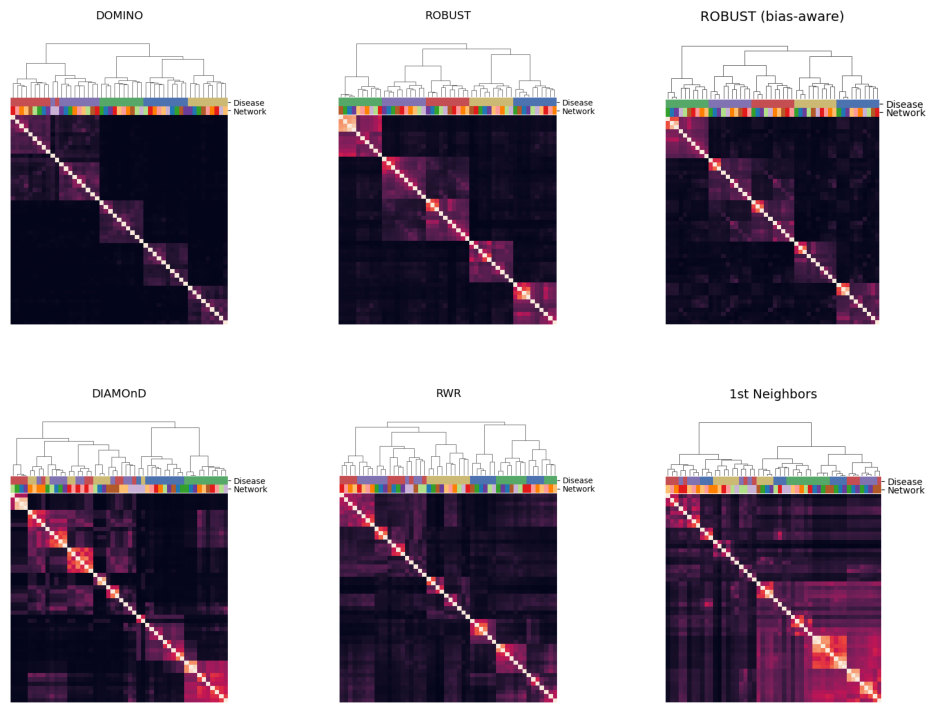

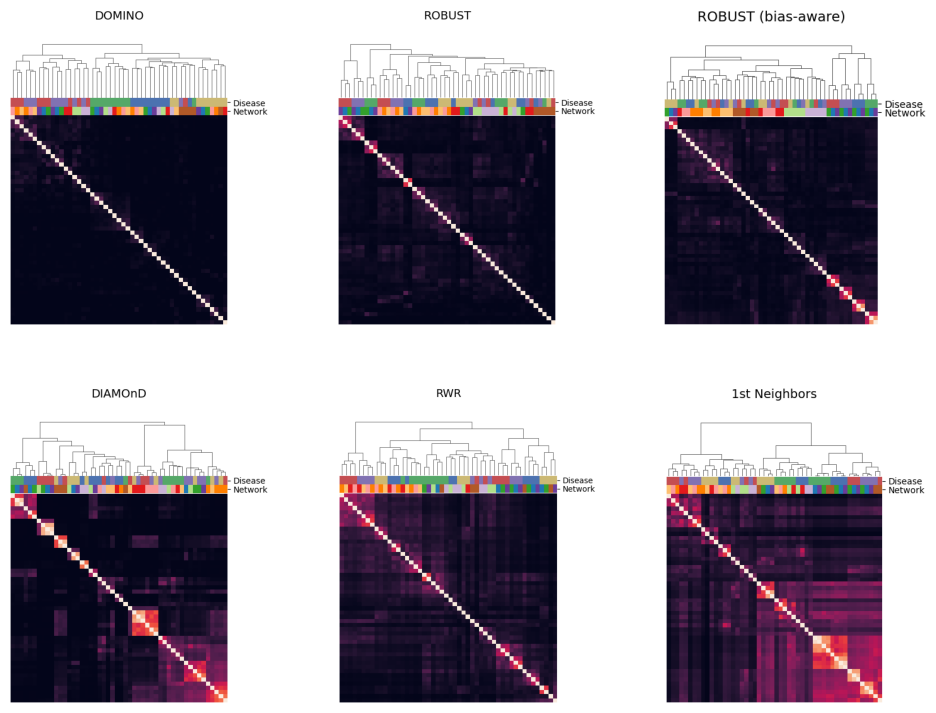

In [5]:
def heatmaps_per_method(df, ann_df, amim_meta_df, network_meta_df, seed_meta_df):
    # Map colors
    color_df = pd.DataFrame()
    color_df["Disease"] = ann_df.seed_id.map(dict(zip(seed_meta_df.short, seed_meta_df.color)))
    color_df["Network"] = ann_df.network_id.map(dict(zip(network_meta_df.id, network_meta_df.color)))

    # Prepare list for storing images
    heatmap_images = []

    # Loop over methods
    for amim_id in amim_meta_df.id:
        method_name = amim_meta_df.loc[amim_meta_df.id == amim_id, "label"].values[0]
        mask = ann_df.amim_id == amim_id
        df_subset = df.loc[mask, mask]
        color_df_subset = color_df.loc[mask]

        # Create clustermap
        g = sns.clustermap(
            data=df_subset,
            col_colors=color_df_subset,
            figsize=(10, 10),  # smaller since we combine later
            cbar_pos=None,   # disable color bar for clarity
            method="ward",
        )

        g.ax_row_dendrogram.set_visible(False)
        g.ax_heatmap.set_xticks([])
        g.ax_heatmap.set_yticks([])
        g.ax_heatmap.set_ylabel("")
        g.ax_heatmap.set_xlabel("")
        g.ax_heatmap.text(
            0.5, 1.45, f"{method_name.replace('\n', ' ')}",
            fontsize=14,
            ha='center',
            va='bottom',
            transform=g.ax_heatmap.transAxes
        )

        #plt.show()
        # Save figure to buffer
        buf = BytesIO()
        g.figure.savefig(buf, format="png", bbox_inches='tight', pad_inches=0.01)
        buf.seek(0)
        img = Image.open(buf)
        heatmap_images.append(img)
        plt.close(g.figure)  # Close to avoid display

    # Create final figure with 3 cols x 2 rows
    fig = plt.figure(figsize=(12, 9))
    gs = GridSpec(2, 3, figure=fig)

    for i, img in enumerate(heatmap_images):
        row = i // 3
        col = i % 3
        ax = fig.add_subplot(gs[row, col])
        ax.imshow(img)
        ax.axis('off')  # Hide axes

    return fig
heatmaps_per_method(df, ann_df, amim_meta_df[amim_meta_df.id!="no_tool"], network_meta_df, seed_meta_df)
save_figure(plt.gcf(), f"{prefix}_heatmaps_per_method")
plt.show()
heatmaps_per_method(no_seeds_df, ann_no_seeds_df, amim_meta_df[amim_meta_df.id!="no_tool"], network_meta_df, seed_meta_df)
save_figure(plt.gcf(), f"{prefix}_heatmaps_per_method_no_seeds")
plt.show()

# Network impact

In [6]:
def overlap_across_networks(df, ann_df, amim_meta_df, seed_meta_df, centered=False, merged_df=None):
    overlap_across_networks_df = []
    for amim_id in amim_meta_df.id:
        for seed_id in seed_meta_df.short:
            mask = (ann_df.amim_id == amim_id) & (ann_df.seed_id == seed_id)
            df_subset = df.loc[mask, mask]
            if centered:
                # If centered, we need to calculate the expected Jaccard index to substract it
                subset_expected_jaccard = np.zeros(df_subset.shape)
                # iterate over the rows and columns of the subset (index and name)
                for i in range(len(df_subset.index)):
                    for j in range(len(df_subset.columns)):
                        # get the index and column name
                        index_name = df_subset.index[i]
                        column_name = df_subset.columns[j]
                        a = merged_df.loc[index_name, "added_nodes_module"]
                        b = merged_df.loc[column_name, "added_nodes_module"]
                        n = max(merged_df.loc[index_name, "nodes_network"], merged_df.loc[column_name, "nodes_network"]) # TODO: taking the maximum here is not entirely correct
                        subset_expected_jaccard[i,j] = expected_jaccard_index(n, b, a)
                df_subset = df_subset.values
                df_subset = df_subset - subset_expected_jaccard
            else:
                # turn into a 2D numpy array
                df_subset = df_subset.values
            # Create a mask for the upper triangle
            upper_triangle = df_subset[np.triu_indices(df_subset.shape[0], k = 1)]
            upper_triangle_df = pd.DataFrame()
            upper_triangle_df["jaccard"] = upper_triangle
            upper_triangle_df["amim_id"] = amim_id
            upper_triangle_df["seed_id"] = seed_id
            overlap_across_networks_df.append(upper_triangle_df)
    overlap_across_networks_df = pd.concat(overlap_across_networks_df)
    overlap_across_networks_df["method"] = overlap_across_networks_df.amim_id.map(dict(zip(amim_meta_df.id, amim_meta_df.label)))
    return overlap_across_networks_df

overlap_across_networks_df = overlap_across_networks(df, ann_df, amim_meta_df, seed_meta_df)
overlap_across_networks_no_seeds_df = overlap_across_networks(no_seeds_df, ann_no_seeds_df, amim_meta_df[amim_meta_df.id!="no_tool"], seed_meta_df)
centered_overlap_across_networks_no_seeds_df = overlap_across_networks(no_seeds_df, ann_no_seeds_df, amim_meta_df[amim_meta_df.id!="no_tool"], seed_meta_df, centered = True, merged_df=merged_df)




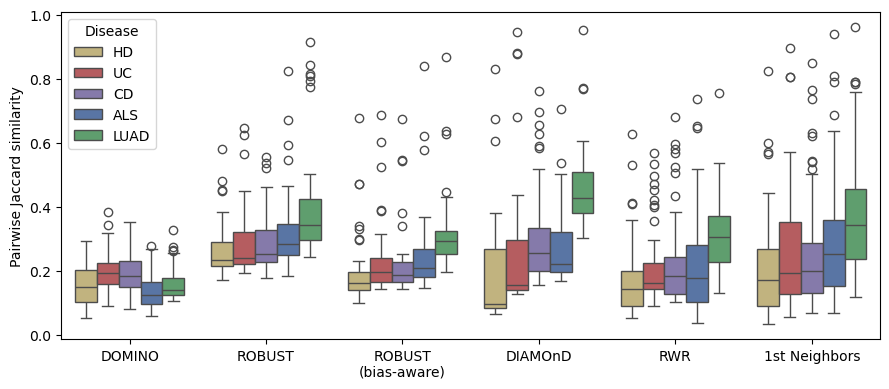

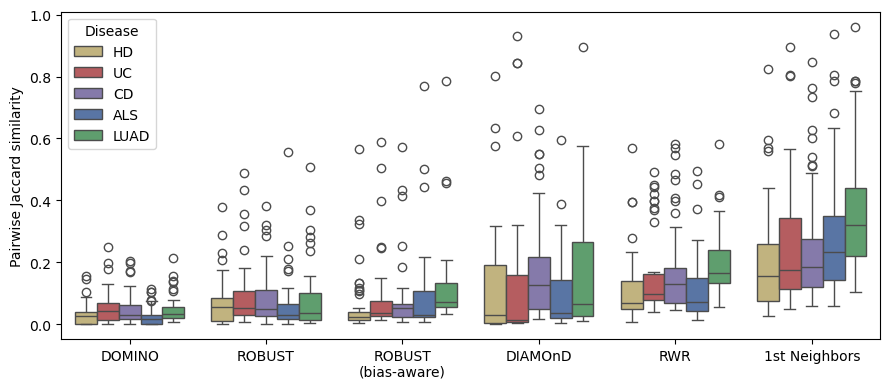

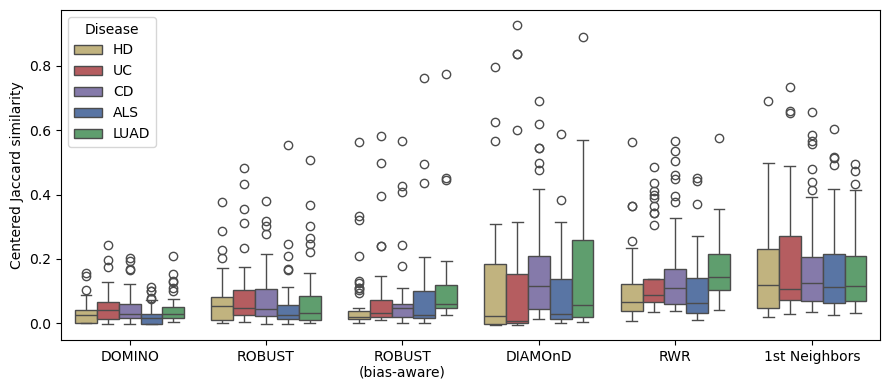

In [7]:
# visualize as boxplot
plt.figure(figsize=(9, 4))
sns.boxplot(
    data=overlap_across_networks_df[overlap_across_networks_df.amim_id != "no_tool"],
    x="method",
    y="jaccard",
    hue="seed_id",
    hue_order=seed_meta_df.short,
    order=amim_meta_df[amim_meta_df.id!="no_tool"].label,
    palette=dict(zip(seed_meta_df.short, seed_meta_df.color)),
)
plt.xlabel("")
plt.ylabel("Pairwise Jaccard similarity")
plt.legend(title="Disease")
plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_overlap_across_networks")
plt.show()

# visualize as boxplot
plt.figure(figsize=(9, 4))
sns.boxplot(
    data=overlap_across_networks_no_seeds_df,
    x="method",
    y="jaccard",
    hue="seed_id",
    hue_order=seed_meta_df.short,
    order=amim_meta_df[amim_meta_df.id!="no_tool"].label,
    palette=dict(zip(seed_meta_df.short, seed_meta_df.color)),
)
plt.xlabel("")
plt.ylabel("Pairwise Jaccard similarity")
plt.legend(title="Disease")
plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_overlap_across_networks_no_seeds")
plt.show()

# visualize as boxplot
plt.figure(figsize=(9, 4))
sns.boxplot(
    data=centered_overlap_across_networks_no_seeds_df,
    x="method",
    y="jaccard",
    hue="seed_id",
    hue_order=seed_meta_df.short,
    order=amim_meta_df[amim_meta_df.id!="no_tool"].label,
    palette=dict(zip(seed_meta_df.short, seed_meta_df.color)),
)
plt.xlabel("")
plt.ylabel("Centered Jaccard similarity")
plt.legend(title="Disease")
plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_centered_overlap_across_networks_no_seeds")
plt.show()

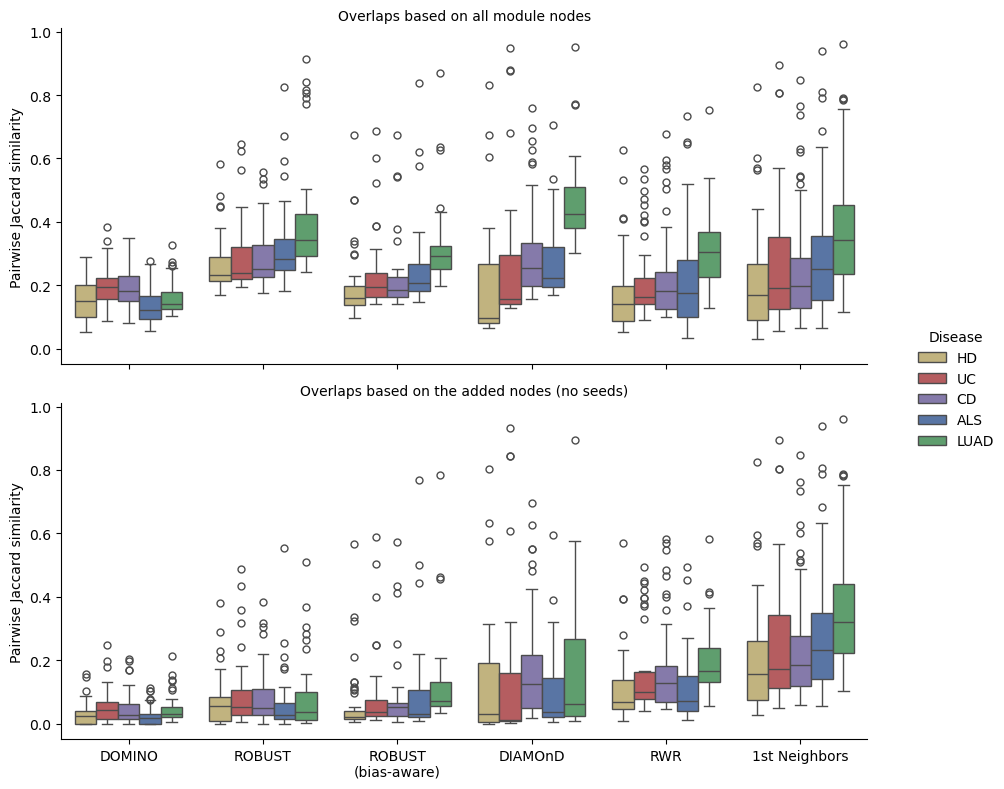

In [8]:
# Add a column to distinguish the two datasets
df1 = overlap_across_networks_df[overlap_across_networks_df.amim_id != "no_tool"].copy()
df1["category"] = "Overlaps based on all module nodes"

df2 = overlap_across_networks_no_seeds_df.copy()
df2["category"] = "Overlaps based on the added nodes (no seeds)"

# Combine the dataframes
combined_df = pd.concat([df1, df2], ignore_index=True)

g = sns.catplot(
    data=combined_df,
    x="method",
    y="jaccard",
    hue="seed_id",
    hue_order=seed_meta_df.short,
    order=amim_meta_df[amim_meta_df.id != "no_tool"].label,
    palette=dict(zip(seed_meta_df.short, seed_meta_df.color)),
    row="category",
    kind="box",
    height=4,
    aspect=2,
    sharex=True,
    sharey=True,
    legend_out=True,
)

# Remove "category=" prefix in facet titles
g.set_titles("{row_name}")

# Axis labels
g.set_axis_labels("", "Pairwise Jaccard similarity")

# Shared legend outside the plot
g._legend.set_title("Disease")
g._legend.set_bbox_to_anchor((1.02, 0.5))
g._legend.set_loc("center left")

plt.tight_layout()
save_figure(plt.gcf(), f"{prefix}_overlap_across_networks_combined")
plt.show()


In [9]:
# just to make sure the expected Jaccard index is correct
import random

def sample_two_sets(n, a, b):
    if a > n or b > n:
        raise ValueError("a and b cannot be greater than n when sampling without replacement within each set.")
    
    elements = list(range(n))
    set1 = random.sample(elements, a)  # sample first set
    set2 = random.sample(elements, b)  # sample second set independently
    
    return set(set1), set(set2)

n = 10000
a = 9000
b = 5000

jaccard_indices = []
for i in range (10000):
    # Example usage:

    set1, set2 = sample_two_sets(n, a, b)
    jaccard_indices.append(len(set1.intersection(set2)) / len(set1.union(set2)))
print("Average empirical Jaccard similarity:", np.mean(jaccard_indices))
print("Expected Jaccard similarity:", expected_jaccard_index(n, a, b))

Average empirical Jaccard similarity: 0.47370844926789396
Expected Jaccard similarity: 0.4736842105263158
